In [1]:
import shap
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport
from deepchecks.tabular import Dataset
from deepchecks.tabular.checks import FeatureDrift

from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from catboost import (
    CatBoostRegressor,
    CatBoostClassifier,
    Pool, 
    cv, 
    EShapCalcType, 
    EFeaturesSelectionAlgorithm
)


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 200)

# Функции

### Функция для расчета метрики

In [2]:
def weighted_mean_absolute_error(y_true, y_pred, weights):

    '''

    Weighted mean absolute error.

    Parameters
    ----------
    y_true: ndarray
        Ground truth
    y_pred: ndarray
        Array of predictions

    Returns
    -------
    rmsle: float
        Weighted mean absolute error

    References
    ----------
    .. [1] https://kaggle-metrics.readthedocs.io/en/latest/_modules/kaggle_metrics/regression.html

    '''
    
    return (weights * np.abs(y_true - y_pred)).mean()

### Функция для обучения базовой модели

In [29]:
def fit_catboost(features_train, 
                 features_val, 
                 target_train, 
                 target_val, 
                 cat_features, 
                 n_iter=500,
                 train_weight=None,
                 val_weight=None):
    
    pool_train = Pool(
        features_train,
        target_train,
        weight = train_weight,
        cat_features = cat_features
    )

    pool_val = Pool(
        features_val,
        target_val,
        weight = val_weight,
        cat_features = cat_features
    )

    model = CatBoostRegressor(
        iterations= n_iter,
        learning_rate=0.05,
        loss_function='RMSE',
        early_stopping_rounds = 15,
        random_seed = 42
    )

    model.fit(
        pool_train,
        eval_set=pool_val,
        verbose=100,
        plot=True
    )

    return model

# Чтение данных

In [4]:
train_df = pd.read_csv('data/train.csv', sep=";", decimal=",", encoding="windows-1251")
test_df = pd.read_csv('data/test.csv', sep=";", decimal=",", encoding="windows-1251")

features_description = (
    pd.read_excel('data/description.xlsx', index_col='field')
    .to_dict()['description']
)

train_df.shape, test_df.shape

((205962, 235), (37183, 233))

# Предварительный анализ EDA

In [5]:
features = list(train_df.drop(['client_id', 'feature_date', 'target', 'w'], axis=1).columns)
train_df[features].select_dtypes('object').head()

,addrref,bki_total_ip_max_limit,hdb_bki_active_cc_cnt,hdb_bki_active_ip_max_outstand,hdb_bki_active_micro_max_outstand,hdb_bki_active_pil_max_overdue,hdb_bki_other_active_auto_month_payments_sum,hdb_bki_total_cc_max_limit,hdb_bki_total_ip_cnt,hdb_bki_total_max_limit,hdb_bki_total_max_overdue_sum,hdb_bki_total_pil_max_limit,main_last_position_ccode,main_pre_last_position_ccode,oldest_campaignsegment_ccode_for_nss,oldest_campaignsegment_ccode_for_pil,part_last_position_ccode,part_pre_last_position_ccode,segment,brand,model
0,Свердловская область,NaN,2.0,1006774.6,NaN,0.0,NaN,170000.0,1.0,4250000.0,235937.0,220000.0,NaN,NaN,NaN,PIL2CC,NaN,NaN,Mass Affluent,NaN,NaN
1,Новосибирская область,NaN,6.0,NaN,NaN,0.0,NaN,110000.0,0.0,183500.0,2527.0,183500.0,NaN,NaN,ACFYN_NZP,PIL2PIL,NaN,NaN,Mass Affluent,NaN,NaN
2,Новосибирская область,NaN,4.0,NaN,NaN,0.0,NaN,65000.0,0.0,558500.0,7678.0,558500.0,NaN,NaN,ACFYN_NZP,PIL2PIL,NaN,NaN,Mass Affluent,NaN,NaN
3,Московская область,NaN,0.0,646694.0,NaN,NaN,NaN,0.0,3.0,1780000.0,0.0,427000.0,NaN,NaN,ACFYN_NZP,PIL2PAY,NaN,NaN,Mass Affluent,NaN,NaN
4,Краснодарский край,NaN,3.0,NaN,NaN,14264.13,NaN,62500.0,0.0,1120000.0,14264.13,1120000.0,NaN,NaN,ACFYN_NZP,PIL2PAY,NaN,NaN,Mass,NaN,NaN


### Поправляем типы данных для фичей

In [6]:
print('Количество униклаьных значений по фиче:')
for f in train_df[features].select_dtypes('object').columns:
    print(f"{f}: {train_df[f].value_counts().count()}")

Количество униклаьных значений по фиче:
addrref: 59
bki_total_ip_max_limit: 2763
hdb_bki_active_cc_cnt: 60
hdb_bki_active_ip_max_outstand: 43267
hdb_bki_active_micro_max_outstand: 5458
hdb_bki_active_pil_max_overdue: 24365
hdb_bki_other_active_auto_month_payments_sum: 3533
hdb_bki_total_cc_max_limit: 9991
hdb_bki_total_ip_cnt: 15
hdb_bki_total_max_limit: 52263
hdb_bki_total_max_overdue_sum: 56162
hdb_bki_total_pil_max_limit: 54202
main_last_position_ccode: 9207
main_pre_last_position_ccode: 5192
oldest_campaignsegment_ccode_for_nss: 56
oldest_campaignsegment_ccode_for_pil: 13
part_last_position_ccode: 1236
part_pre_last_position_ccode: 1325
segment: 3
brand: 422
model: 2397


В соответствии с описанием фичей было выяснено, что для всех фичей, которые начинаются с 'hdb_bki' требуется выставить тип данных float

In [7]:
newtype_feats = [
    'bki_total_ip_max_limit',
    'hdb_bki_active_cc_cnt',
    'hdb_bki_active_ip_max_outstand',
    'hdb_bki_active_micro_max_outstand',
    'hdb_bki_active_pil_max_overdue',
    'hdb_bki_other_active_auto_month_payments_sum',
    'hdb_bki_total_cc_max_limit',
    'hdb_bki_total_ip_cnt',
    'hdb_bki_total_max_limit',
    'hdb_bki_total_max_overdue_sum',
    'hdb_bki_total_pil_max_limit'
]

test_df[newtype_feats] = test_df[newtype_feats].astype('float64')
test_df['feature_date'] = test_df['feature_date'].astype('datetime64[ns]')

train_df[newtype_feats] = train_df[newtype_feats].astype('float64')
train_df['feature_date'] = train_df['feature_date'].astype('datetime64[ns]')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205962 entries, 0 to 205961
Columns: 235 entries, client_id to productionyear
dtypes: datetime64[ns](1), float64(223), int64(1), object(10)
memory usage: 369.3+ MB


In [8]:
cat_features = list(train_df[features].select_dtypes('object').columns)
num_features = list(set(features) - set(cat_features))

len(features), len(cat_features), len(num_features)

(231, 10, 221)

### Анализ категорильных фичей

In [9]:
# сколько всего записей, где известна должность, но не известна зп?
train_df.loc[
    (train_df['worksalary_rur_amt'].isna())
    & (~train_df['part_last_position_ccode'].isna())
].shape

(4184, 235)

In [10]:
# df, содержащий медианные зарплаты для должностей по всем данным
median_worksalary = (
    pd.concat([train_df[features], test_df[features]], axis=0)
    .dropna(subset = 'worksalary_rur_amt')
    .groupby('part_last_position_ccode', as_index=False)
    ['worksalary_rur_amt'].median()
    .rename(columns={'worksalary_rur_amt': 'median_worksalary_rur_amt'})
)
median_worksalary.head()

,part_last_position_ccode,median_worksalary_rur_amt
0,АВТОМЕХАНИК,158892.5
1,АДМИНИСТРАТОР,180000.0
2,АНАЛИТИК,100000.0
3,Администратор,60000.0
4,Администратор магазина,70000.0


In [11]:
test_df = test_df.merge(median_worksalary, on='part_last_position_ccode', how='left')
test_df['worksalary_rur_amt'] = test_df['worksalary_rur_amt'].fillna(test_df['median_worksalary_rur_amt'])
test_df.drop('median_worksalary_rur_amt', axis=1, inplace=True)

train_df = train_df.merge(median_worksalary, on='part_last_position_ccode', how='left')
train_df['worksalary_rur_amt'] = train_df['worksalary_rur_amt'].fillna(train_df['median_worksalary_rur_amt'])
train_df.drop('median_worksalary_rur_amt', axis=1, inplace=True)

train_df.loc[
    (train_df['worksalary_rur_amt'].isna())
    & (~train_df['part_last_position_ccode'].isna())
].shape

(1029, 235)

In [12]:
# заполняем пропуски в категориальных
train_df[cat_features] = train_df[cat_features].fillna('miss_value')
test_df[cat_features] = test_df[cat_features].fillna('miss_value')

# Инженерия фич

In [13]:
train_df['feature_date_year'] = train_df['feature_date'].dt.year
train_df['feature_date_month'] = train_df['feature_date'].dt.month
train_df['feature_date_day'] = train_df['feature_date'].dt.day

test_df['feature_date_year'] = test_df['feature_date'].dt.year
test_df['feature_date_month'] = test_df['feature_date'].dt.month
test_df['feature_date_day'] = test_df['feature_date'].dt.day

### Получаем предсказания модели, которая предсказывает сегмент доходности клиента (model_clf)

In [14]:
clf_model = CatBoostClassifier()
clf_model.load_model('models/bin_model_clf')

q = train_df['target'].quantile(0.9)
train_df['target_bins'] = train_df['target'].apply(lambda x:  0 if x < q else 1)

train_df['cl0_prob'] = clf_model.predict_proba(train_df[clf_model.feature_names_])[:,0]
train_df['cl1_prob'] = clf_model.predict_proba(train_df[clf_model.feature_names_])[:,1]

test_df['target_bins'] = clf_model.predict(test_df[clf_model.feature_names_])
test_df['cl0_prob'] = clf_model.predict_proba(test_df[clf_model.feature_names_])[:,0]
test_df['cl1_prob'] = clf_model.predict_proba(test_df[clf_model.feature_names_])[:,1]
test_df.head()

,client_id,feature_date,accum_rur_amt_cm_avg_div_v2,addrref,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__bilety_na_kontserty_i_v_teatry,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__brokerskie_uslugi,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__hosting,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__spa_sauny_bani,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__tovary_dlja_detej,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__turisticheskie_agenstva,amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__marketplejsy,amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__nalogi,amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__ohota_i_rybalka,amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__prochie_bilety,atravel,avg_3m_hotels,avg_6m_building_services,avg_6m_money_transactions,avg_6m_personal_services,avg_6m_transportation,avg_by_category__amount__sum__cashflowcategory_name__detskie_igrushki,avg_by_category__amount__sum__cashflowcategory_name__investitsii,avg_by_category__amount__sum__cashflowcategory_name__odezhda_dlja_beremennyh,avg_by_category__amount__sum__cashflowcategory_name__vydacha_nalichnyh_v_bankomate,avg_by_category__amount__sum__cashflowcategory_name__zdorove,avg_by_category__amount__sum__cashflowcategory_name__zooparki,avg_cnt_daily_transactions_90d,avg_debet_turn_rur,avg_percents_inc,bki_total_ip_max_limit,by_category__amount__sum__eoperation_type_name__perevod_mezhdu_svoimi_schetami,by_category__amount__sum__eoperation_type_name__platezh_cherez_vidzhet_moj_mobilnyj,by_category__amount__sum__eoperation_type_name__pokupka_paja,by_category__amount__sum__eoperation_type_name__vneshnij_perevod_rur,calls_weight_v2,card_dda_rur_amt_cm_avg_div_v2,cc_other_rate_max_2avg_prop,channel_agentskij_kanal_voc_features_12m_avg_mark,channel_agentskij_kanal_voc_features_12m_cnt_mark,channel_bankomaty_voc_features_36m_avg_mark,channel_bankomaty_voc_features_36m_voc_without_marks_portion,channel_bankomaty_voc_features_3m_mark_eq_5_flag,channel_bankomaty_voc_features_full_mark_eq_5_flag,channel_bankomaty_voc_features_full_voc_not_null_flag,channel_chat_s_operatorom_alfainvestitsii_voc_features_12m_avg_mark,channel_chat_s_operatorom_alfainvestitsii_voc_features_36m_mark_not_null_flag,channel_chat_s_operatorom_voc_features_12m_cnt_mark,channel_chat_s_operatorom_voc_features_12m_mark_eq_3_flag,channel_chat_s_operatorom_voc_features_12m_voc_with_expert_cnt,channel_chat_s_operatorom_voc_features_3m_mark_eq_4_flag,channel_chat_s_operatorom_voc_features_full_voc_without_marks_portion,channel_chatbot_alfainvestitsii_voc_features_12m_mark_in_4_5_flag,channel_chatbot_alfainvestitsii_voc_features_12m_voc_with_expert_portion,channel_chatbot_alfainvestitsii_voc_features_36m_mark_eq_3_flag,channel_chatbot_alfainvestitsii_voc_features_36m_min_mark,channel_chatbot_alfainvestitsii_voc_features_3m_mark_eq_5_flag,channel_chatbot_alfainvestitsii_voc_features_3m_mark_in_4_5_flag,channel_chatbot_alfainvestitsii_voc_features_full_avg_mark,channel_chatbot_voc_features_12m_mark_in_1_3_flag,channel_chatbot_voc_features_12m_voc_with_expert_portion,channel_chatbot_voc_features_full_voc_without_marks_portion,channel_collection_voc_features_36m_cnt_mark,channel_collection_voc_features_36m_mark_eq_2_flag,channel_collection_voc_features_36m_voc_not_null_flag,channel_collection_voc_features_3m_voc_with_expert_portion,channel_collection_voc_features_full_voc_without_marks_portion,channel_finansovyj_sovetnik_voc_features_36m_avg_mark,channel_finansovyj_sovetnik_voc_features_3m_voc_with_expert_portion,channel_finansovyj_sovetnik_voc_features_full_avg_mark,channel_finansovyj_sovetnik_voc_features_full_voc_with_expert_cnt,channel_frodmonitoring_voc_features_12m_mark_eq_2_flag,channel_frodmonitoring_voc_features_12m_max_mark,channel_frodmonitoring_voc_features_3m_mark_in_4_5_flag,channel_frodmonitoring_v

In [15]:
features = list(train_df.drop(['client_id', 'feature_date', 'target', 'w', 'target_bins'], axis=1).columns)

cat_features = list(train_df[features].select_dtypes('object').columns)
num_features = list(set(features) - set(cat_features))

len(features), len(cat_features), len(num_features)

(236, 10, 226)

# Обучение модели

In [16]:
features_train, features_val, target_train, target_val = train_test_split(
    train_df[features],
    train_df['target'],
    test_size=0.3,
    random_state=42
)

w_train, w_val, bins_train, bins_val = train_test_split(
    train_df['w'],
    train_df['target_bins'],
    test_size=0.3,
    random_state=42
)

## Обучение модели на всех фичах с фичами от классификатора

In [17]:
model = fit_catboost(
    features_train,
    features_val,
    target_train, 
    target_val, 
    cat_features, 
    500
)

WMAE = weighted_mean_absolute_error(target_val, model.predict(features_val), w_val)
print(f"WMAE = {WMAE:.2f}")
print(f"Overfit: {model.evals_result_['validation']['RMSE'][-1] - model.evals_result_['learn']['RMSE'][-1]}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 86162.4499223	test: 86349.5882414	best: 86349.5882414 (0)	total: 290ms	remaining: 2m 24s
100:	learn: 56742.8515688	test: 57154.6716581	best: 57154.6716581 (100)	total: 16.3s	remaining: 1m 4s
200:	learn: 55628.4435274	test: 56548.8487445	best: 56548.8487445 (200)	total: 32.5s	remaining: 48.3s
300:	learn: 54823.6726140	test: 56330.8520699	best: 56330.8520699 (300)	total: 47.9s	remaining: 31.7s
400:	learn: 54092.0942935	test: 56152.4423289	best: 56152.4423289 (400)	total: 1m 4s	remaining: 15.9s
499:	learn: 53419.8215026	test: 56044.9778880	best: 56043.3312276 (498)	total: 1m 22s	remaining: 0us

bestTest = 56043.33123
bestIteration = 498

Shrink model to first 499 iterations.
WMAE = 30001.69
Overfit: 2625.15638539676


Text(0.5, 1.0, 'Residual Plot')

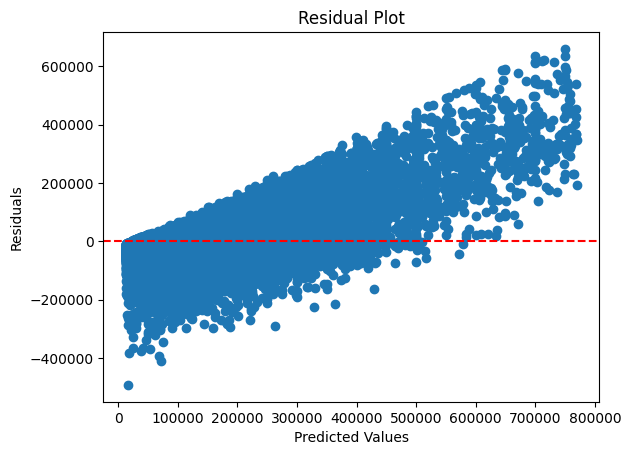

In [18]:
# Plot Residuals
residuals = target_val - model.predict(features_val)
plt.scatter(target_val, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

d:\ml\income-prediction-alfa-campus\.venv\Lib\site-packages\shap\plots\_beeswarm.py:960: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



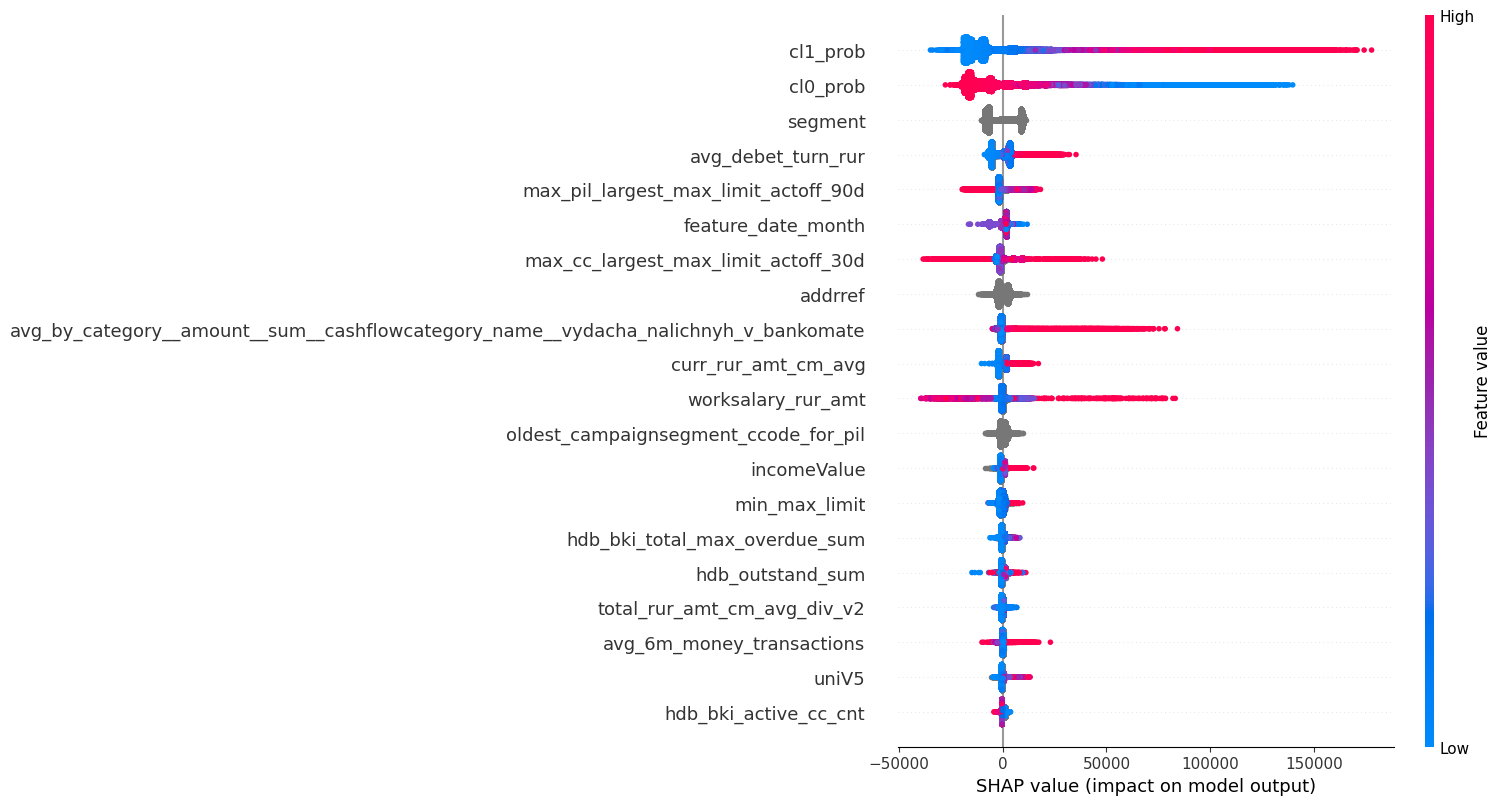

In [19]:
shap_values = (
    shap
    .TreeExplainer(model)
    .shap_values(features_val)
)
shap.summary_plot(shap_values, features_val)

In [20]:
shap_importance = (
    pd.DataFrame(
        {"feature":  features_train.columns, "importance": np.mean(np.abs(shap_values), axis=0)}
    ).sort_values("importance", ascending=False, ignore_index=True)
)
shap_importance.head()

,feature,importance
0,cl1_prob,20030.495940
1,cl0_prob,17332.798176
2,segment,7453.885365
3,avg_debet_turn_rur,4126.331779
4,max_pil_largest_max_limit_actoff_90d,2580.402706


## Отбор фич (факторный анализ)

In [21]:
# по пропущенным значениям

def feats_filter_nan(df: pd.DataFrame,
                     num_feat: list,
                     cat_feat: list,
                     nan_threshold: float):

    """Функция отбора фичей по доле NaN-значений.
    Фичи, которые имеют долю NaN-значений не ниже заданного nan_threshold, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    num_feat : list
        список числовых фичей
    cat_feat : list
        список категориальных фичей (в нашем случае для них NaN-значением является 'miss_value')
    nan_threshold : float
        порог удаления фичи

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    # для числовых фичей
    nan_stats_num = (
        df[num_feat]
        .isna().mean(axis=0)
        .reset_index()
        .rename(columns={0: 'nan_frac', 'index': 'col'})
    )
    # для категориальных
    nan_stats_cat = (
        (df[cat_feat] == 'miss_value')
        .mean(axis=0)
        .reset_index()
        .rename(columns={0: 'nan_frac', 'index': 'col'})
    )

    nan_stats = pd.concat([nan_stats_num, nan_stats_cat])
    selected_features = list(nan_stats[nan_stats['nan_frac'] < nan_threshold]['col'])

    return selected_features


deleted_features = list(set(features) - set(feats_filter_nan(train_df, num_features, cat_features, 0.95)))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = feats_filter_nan(train_df, num_features, cat_features, 0.95)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

,feature,importance
27,first_salary_income,326.929204
43,product_depozity_voc_features_full_voc_without...,121.447578
50,hdb_bki_other_active_auto_month_payments_sum,84.166940
52,brand,75.068698
70,avg_by_category__amount__sum__cashflowcategory...,44.529984
74,bki_total_ip_max_limit,43.070899
100,transaction_category_hotels_sum_amt_d15,22.069127
102,min_cc_max_pilot_score_actoff_180d,20.616710
103,part_last_position_ccode,20.063473
120,unique_countries1,11.539818


148

Отброшены потенцильно хорошие фичи. Вернем их в список фичей

In [22]:
selected_features += list(
    shap_importance.loc[shap_importance.feature.isin(deleted_features), 'feature'].values[:5]
)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

153

In [23]:
# по доле самого частого значения

def feats_filter_nunique(df: pd.DataFrame,
                         features: list,
                         unique_threshold: float):

    """Функция отбора фичей по доле самого частого значения.
    Фичи, которые имеют 1 уникальное значение (помимо NaN), либо для которых
      доля самого частого значения (включая NaN) не ниже unique_threshold, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    features : list
        список фичей
    unique_threshold : float
        порог удаления фичи

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    selected_features = []

    for feat in features:
        if df[feat].nunique() >= 2 and df[feat].astype(str).value_counts(1).values[0] < unique_threshold:
            selected_features += [feat]

    return selected_features

deleted_features = list(set(selected_features) - set(feats_filter_nunique(train_df, selected_features, 0.95)))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = feats_filter_nunique(train_df, selected_features, 0.95)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

,feature,importance
27,first_salary_income,326.929204
43,product_depozity_voc_features_full_voc_without...,121.447578
50,hdb_bki_other_active_auto_month_payments_sum,84.166940
52,brand,75.068698
70,avg_by_category__amount__sum__cashflowcategory...,44.529984
99,channel_bankomaty_voc_features_full_voc_not_nu...,22.782853
183,channel_otdelenija_voc_features_full_voc_not_n...,0.000000
229,loan_on_realty_clicks_90,0.000000


145

In [24]:
selected_features += list(
    shap_importance.loc[shap_importance.feature.isin(deleted_features), 'feature'].values[:5]
)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

150

In [25]:
# отсечение по рандомной фиче

def feats_filter_random_feat(df: pd.DataFrame,
                             features: list,
                             cat_features: list):

    """Функция отбора фичей при помощи отсечения менее важных фичей чем рандомная фича.
    Фичи, которые имеют в простой модели важность ниже рандомной фичи, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    features : list
        список фичей
    cat_features : list
        список категориальных фичей

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    df['random'] = np.random.uniform(0, 1, df.shape[0])

    pool_train = Pool(
        df[features + ['random']],
        df['target'],
        cat_features = cat_features
    )

    simple_model = CatBoostRegressor(
        iterations=400,
        learning_rate=0.05,
        loss_function='RMSE',
        random_seed = 42
    )

    simple_model.fit(
        pool_train,
        verbose=100
    )

    shap_values = (
        shap
        .TreeExplainer(simple_model)
        .shap_values(df[features + ['random']])
    )

    model_importance = (
        pd.DataFrame(
            {"feature":  features + ['random'], "importance": np.mean(np.abs(shap_values), axis=0)}
        ).sort_values("importance", ascending=False, ignore_index=True)
    )

    selected_features = list(
        model_importance[
            model_importance['importance'] 
            > model_importance.loc[model_importance['feature'] == 'random', 'importance'].values[0]
        ]['feature']
    )

    return selected_features


_selected_features = feats_filter_random_feat(train_df, selected_features, selected_features_cat)
deleted_features = list(set(selected_features) - set(_selected_features))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = _selected_features
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

0:	learn: 86188.2935005	total: 157ms	remaining: 1m 2s
100:	learn: 56808.2726651	total: 15.3s	remaining: 45.3s
200:	learn: 55799.3140951	total: 29.8s	remaining: 29.5s
300:	learn: 55029.8680555	total: 44.3s	remaining: 14.6s
399:	learn: 54345.4766499	total: 58.6s	remaining: 0us


,feature,importance
52,brand,75.068698
54,transaction_category_general_store_inc_cnt_2m,68.899499
61,flg_nss_presence_in_previous_30_days_with_150_...,55.077575
75,voc_features_full_mark_eq_3_flag,43.023178
78,channel_telemarketing_voc_features_36m_mark_in...,38.998373
79,channel_chat_s_operatorom_voc_features_12m_cnt...,38.465125
82,summarur_1m_miscellaneous_stores,33.305330
83,product_brokerskoe_obsluzhivanie_voc_features_...,33.041205
84,channel_chatbot_voc_features_full_voc_without_...,31.901796
86,product_zarplatnaja_karta_voc_features_3m_voc_...,29.539595


97

In [27]:
selected_features += list(
    shap_importance.loc[shap_importance.feature.isin(deleted_features), 'feature'].values[:1]
)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

98

## Обучение модели на фичах после факторного анализа

In [28]:
model = fit_catboost(
    features_train[selected_features], 
    features_val[selected_features], 
    target_train, 
    target_val, 
    selected_features_cat, 
    450
)

WMAE = weighted_mean_absolute_error(target_val, model.predict(features_val[selected_features]), w_val)
print(f"WMAE = {WMAE:.2f}")
print(f"Overfit: {model.evals_result_['validation']['RMSE'][-1] - model.evals_result_['learn']['RMSE'][-1]}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 86155.6447442	test: 86344.1975051	best: 86344.1975051 (0)	total: 134ms	remaining: 60s
100:	learn: 56720.5938202	test: 57156.0583905	best: 57156.0583905 (100)	total: 12.4s	remaining: 42.9s
200:	learn: 55556.7897295	test: 56605.6112277	best: 56605.6112277 (200)	total: 24.1s	remaining: 29.8s
300:	learn: 54656.6365629	test: 56316.1056841	best: 56316.1056841 (300)	total: 36.4s	remaining: 18s
400:	learn: 53856.8864326	test: 56117.4610201	best: 56117.4610201 (400)	total: 48.8s	remaining: 5.96s
449:	learn: 53490.8968240	test: 56075.1674998	best: 56075.1674998 (449)	total: 55s	remaining: 0us

bestTest = 56075.1675
bestIteration = 449

WMAE = 29990.12
Overfit: 2584.270675749205


Text(0.5, 1.0, 'Residual Plot')

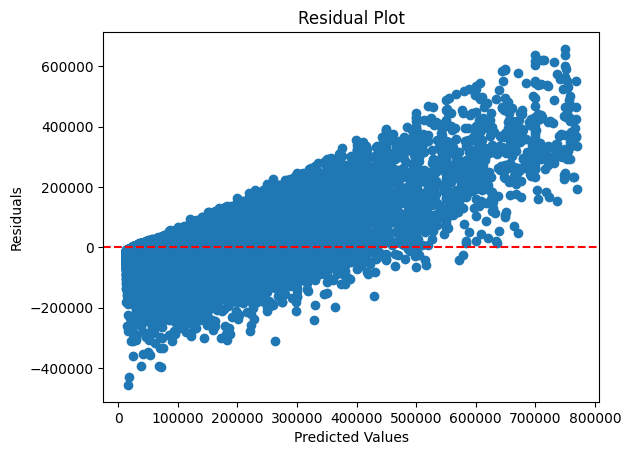

In [30]:
# Plot Residuals
residuals = target_val - model.predict(features_val[selected_features])
plt.scatter(target_val, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

## Обучение моделей на каждый бин на выбранных фичах

In [31]:
# модель на нулевом бине
bin0_model = fit_catboost(
    features_train.loc[bins_train == 0, selected_features], 
    features_val.loc[bins_val == 0, selected_features], 
    target_train.loc[bins_train == 0], 
    target_val.loc[bins_val == 0], 
    selected_features_cat, 
    400
)

WMAE = weighted_mean_absolute_error(
    target_val.loc[bins_val == 0], 
    bin0_model.predict(features_val.loc[bins_val == 0, selected_features]), 
    w_val
)
print(f"WMAE = {WMAE:.2f}")
print(f"Overfit: {bin0_model.evals_result_['validation']['RMSE'][-1] - bin0_model.evals_result_['learn']['RMSE'][-1]}")

# модель на первом бине
bin1_model = fit_catboost(
    features_train.loc[bins_train == 1, selected_features], 
    features_val.loc[bins_val == 1, selected_features], 
    target_train.loc[bins_train == 1], 
    target_val.loc[bins_val == 1], 
    selected_features_cat, 
    400
)

WMAE = weighted_mean_absolute_error(
    target_val.loc[bins_val == 1], 
    bin1_model.predict(features_val.loc[bins_val == 1, selected_features]), 
    w_val
)
print(f"WMAE = {WMAE:.2f}")
print(f"Overfit: {bin1_model.evals_result_['validation']['RMSE'][-1] - bin1_model.evals_result_['learn']['RMSE'][-1]}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 34803.1584849	test: 34771.8833432	best: 34771.8833432 (0)	total: 128ms	remaining: 50.9s
100:	learn: 25030.0977740	test: 25081.7180709	best: 25081.7180709 (100)	total: 11.6s	remaining: 34.4s
200:	learn: 24465.0328777	test: 24596.8941115	best: 24596.8941115 (200)	total: 23.2s	remaining: 23s
300:	learn: 24097.6215359	test: 24333.4079337	best: 24333.4079337 (300)	total: 35s	remaining: 11.5s
399:	learn: 23820.7098332	test: 24172.5388727	best: 24172.5388727 (399)	total: 46.5s	remaining: 0us

bestTest = 24172.53887
bestIteration = 399

WMAE = 7877.53
Overfit: 351.82903951514527


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 128221.4619685	test: 128064.0168106	best: 128064.0168106 (0)	total: 46ms	remaining: 18.4s
100:	learn: 107092.3266835	test: 109583.2435414	best: 109583.2435414 (100)	total: 4.74s	remaining: 14s
200:	learn: 103434.7465398	test: 108231.7871648	best: 108231.7871648 (200)	total: 9.38s	remaining: 9.29s
300:	learn: 100041.5637893	test: 107535.8857335	best: 107535.8857335 (300)	total: 14.1s	remaining: 4.64s
399:	learn: 97271.6126876	test: 107223.7870604	best: 107223.7870604 (399)	total: 18.8s	remaining: 0us

bestTest = 107223.7871
bestIteration = 399

WMAE = 150212.14
Overfit: 9952.174372791618


In [32]:
pred = pd.DataFrame(np.nan, index=target_val.index, columns = ['pred'])

pred.loc[bins_val == 0, 'pred'] = bin0_model.predict(features_val.loc[bins_val == 0, selected_features])
pred.loc[bins_val == 1, 'pred'] = bin1_model.predict(features_val.loc[bins_val == 1, selected_features])

In [33]:
WMAE = weighted_mean_absolute_error(
    target_val, 
    pred['pred'], 
    w_val
)
print(f"WMAE = {WMAE:.2f}")

WMAE = 22168.81


Text(0.5, 1.0, 'Residual Plot')

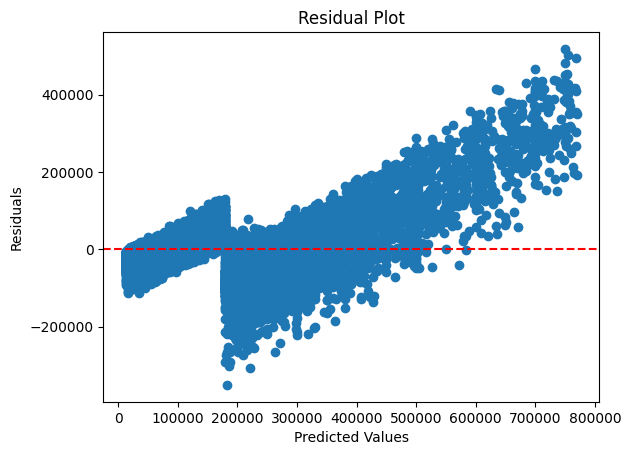

In [34]:
# Plot Residuals
residuals = target_val - pred['pred']
plt.scatter(target_val, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Инференс

In [38]:
bin0_pool_train = Pool(
    train_df.loc[train_df['target_bins'] == 0, selected_features],
    train_df.loc[train_df['target_bins'] == 0, 'target'],
    cat_features = selected_features_cat
)

bin0_model = CatBoostRegressor(
    iterations=350,
    learning_rate=0.05,
    loss_function='RMSE'
)

bin0_model.fit(
    bin0_pool_train,
    verbose=100,
    plot=True
)


bin1_pool_train = Pool(
    train_df.loc[train_df['target_bins'] == 1, selected_features],
    train_df.loc[train_df['target_bins'] == 1, 'target'],
    cat_features = selected_features_cat
)

bin1_model = CatBoostRegressor(
    iterations=200,
    learning_rate=0.05,
    loss_function='RMSE'
)

bin1_model.fit(
    bin1_pool_train,
    verbose=100,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 34806.9880379	total: 137ms	remaining: 47.6s
100:	learn: 25042.4188237	total: 13.5s	remaining: 33.2s
200:	learn: 24478.5431194	total: 27.6s	remaining: 20.4s
300:	learn: 24139.5764194	total: 41.8s	remaining: 6.81s
349:	learn: 24008.3997190	total: 48.6s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 128072.9016338	total: 117ms	remaining: 23.2s
100:	learn: 107448.9346094	total: 5.46s	remaining: 5.35s
199:	learn: 104421.0048793	total: 10.5s	remaining: 0us


# Commit

In [48]:
test_df['predict'] = None
test_df.loc[test_df['target_bins'] == 0, 'predict'] = bin0_model.predict(test_df.loc[test_df['target_bins'] == 0, selected_features])
test_df.loc[test_df['target_bins'] == 1, 'predict'] = bin1_model.predict(test_df.loc[test_df['target_bins'] == 1, selected_features])
test_df[['client_id','predict']].set_index('client_id').to_csv("data/commit.csv", sep=",", decimal=".")